# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

df = pd.read_csv('lin_reg.txt', header=None)
mapper = {
    0: 'x1',
    1: 'x2',
    2: 'x3',
    3: 'x4',
    4: 'y',
}
df.rename(columns=mapper, inplace=True)

X = df[['x1', 'x2', 'x3', 'x4']].values
Y = df[['y']].values

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [2]:
def forward_pass(w, X):
    b = w[0] * np.ones((X.shape[0], 1))
    w = w[1:]
    assert w.shape[0] == X.shape[1]
    assert b.shape[0] == X.shape[0]
    return  (X @ w).reshape(-1, 1) + b.reshape(-1, 1)

In [3]:
def J(w, X, Y, a = 0):
    return np.sum(np.power(forward_pass(w, X) - Y, 2)) / len(Y) + a * (np.sum(np.power(w, 2)))

In [4]:
def train_test_split(X, train_size=0.75):
    n = X.shape[0]
    k = int(n * train_size)
    return X[:k], X[k:]

In [5]:
def train_test_split_df(df):
    train, test = train_test_split(df)
    X_train = train[['x1', 'x2', 'x3', 'x4']].values
    X_test = test[['x1', 'x2', 'x3', 'x4']].values
    Y_train = train[['y']].values
    Y_test = test[['y']].values
    return X_train, X_test, Y_train, Y_test

In [6]:
def fit_lin(X, Y, a = 0, plot = False):
    arch = {
        'w': [],
        'er': [],
    }
    
    def callback(w):
        arch['w'].append(w)
        arch['er'].append(J(w, X, Y))
    w_opt = minimize(J, x0=np.zeros((X.shape[1] + 1, 1)), args=(X, Y, a), callback=callback, method='BFGS').x
    
    if plot:
        plot_curve(arch)
    return w_opt, arch

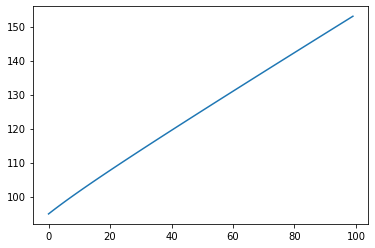

In [7]:
er_list = []
for a in np.linspace(0, 1, 100):
    w_opt, _ = fit_lin(X, Y, a = a)
    er = J(w_opt, X, Y, a = a)
    er_list.append(er)
    
plt.plot(er_list)

In [8]:
def cross_val(df, cv = 5, a = 0):
    df_mix = df.sample(frac = 1)
    n = len(df_mix)
    step = n // cv
    
    arch = {
        'train_er': [],
        'test_er': []
    }
    for i in range(0, n, step):
        fold = df_mix[i:i + step]
        X_train, X_test, Y_train, Y_test = train_test_split_df(fold)
        w_opt, _ = fit_lin(X_train, Y_train, a = a)
        arch['train_er'].append(J(w_opt, X_train, Y_train))
        arch['test_er'].append(J(w_opt, X_test, Y_test))
    return arch

In [9]:
def mean_cv_arch(arch):
    return np.array(arch['test_er']).mean()

In [10]:
mean_er_list = {}
for a in np.linspace(0, 1, 30):
    arch_cv = cross_val(df, a = a)  
    mean_er_list[a] = mean_cv_arch(arch_cv)
min_val = sorted(mean_er_list.items(), key=lambda x: x[1])[0]
a_opt = min_val[0]
print(f'a_opt = {min_val[0]}, MSE = {min_val[1]}')

a_opt = 0.5517241379310345, MSE = 83.0314158373985


In [11]:
def plot_curve(arch, X_test, Y_test, a_opt):
    val_list = []
    for w in arch['w']:
        val_list.append(J(w, X_test, Y_test, a = a_opt))
    
    plt.figure()
    
    plt.plot(arch['er'])
    plt.plot(val_list)
    
    plt.legend(['train', 'test'])

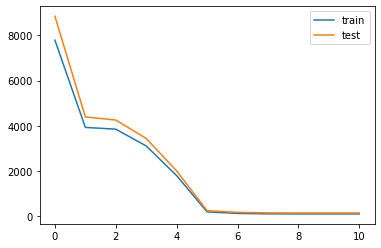

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split_df(df)

w, arch = fit_lin(X_train, Y_train, a = a_opt)

plot_curve(arch, X_test, Y_test, a_opt)